In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import openmc_source_plotter
import neutronics_material_maker as nmm
import openmc_source_plotter

In [2]:


#Lupin materials

#lead casing
lead = openmc.Material(name='lead')
lead.add_element('Pb', 1, 'ao')
lead.set_density('g/cm3', 11.34)
#aluminium shell
al = openmc.Material(name='aluminium')
al.add_element('Al', 1, 'ao')
al.set_density('g/cm3', 2.7)
al.add_s_alpha_beta("c_Al27")
#cadmium
cadmium = openmc.Material(name='cadmium')
cadmium.add_element('Cd', 1, 'ao')
cadmium.set_density('g/cm3', 4.047)
#BF3
bf3 = nmm.Material.from_library('Boron Fluoride (BF3)', temperature=294, pressure=26664).openmc_material
#bf3.set_density("atom/b-cm",7.3e-4)
#polyethylene
polyethylene = openmc.Material(name='polyethylene')
polyethylene.add_elements_from_formula('C2H4')
polyethylene.set_density('g/cm3',0.93)
polyethylene.add_s_alpha_beta('c_H_in_CH2')


materials = openmc.Materials([lead, al, cadmium, bf3, polyethylene])
materials.export_to_xml()



In [3]:
#geometry dimensions
cylinder_radius = 5.4
detector_radius = 2
active_radius = 2.54/2
outer_cylinder_radius = 12.5
lead_thickness = 0.15
shielding_thickness = 0.15

lead_height = 14.1
b_detector_height = 4.7
#active_detector_height = 15
cylinder_height = 29.7
big_cd_height = 5
small_cd_height = 2.5

cd_thickness = 0.15
cd_gap = 2.425

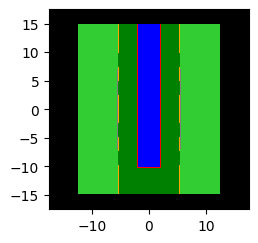

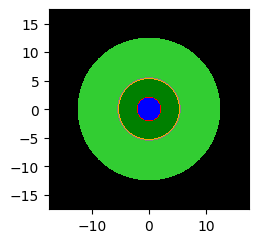

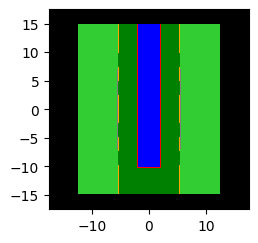

In [4]:
#geometry model

detector = openmc.ZCylinder(r=detector_radius)
#active_detector = openmc.ZCylinder(r=active_radius)
shielding = openmc.ZCylinder(r=detector_radius + shielding_thickness)
inner_cylinder = openmc.ZCylinder(r=cylinder_radius)
lead_plate = openmc.ZCylinder(r=cylinder_radius + lead_thickness)
cd_cylinder = openmc.ZCylinder(r=cylinder_radius - (cd_thickness))
outer_cylinder = openmc.ZCylinder(r=outer_cylinder_radius)
source_sphere = openmc.Sphere(r=50)
outer_void = openmc.Sphere(r=55, boundary_type='vacuum')

top_cylinder = openmc.ZPlane(z0=0.5*cylinder_height)
bottom_cylinder = openmc.ZPlane(z0=-0.5*cylinder_height)
bottom_detector = openmc.ZPlane(z0=-0.5*cylinder_height + b_detector_height)
bottom_shielding = openmc.ZPlane(z0=-0.5*cylinder_height + b_detector_height-shielding_thickness)
top_lead = openmc.ZPlane(z0=0.5*lead_height)
bottom_lead = openmc.ZPlane(z0=-0.5*lead_height)
top_wall_cylinder = openmc.ZPlane(z0=0.5*cylinder_height+0.1)

#top_active_detector = openmc.ZPlane(z0=0.5*(cylinder_height-active_detector_height))
#bottom_active_detector = openmc.ZPlane(z0=0.5*(-cylinder_height+active_detector_height))

cd_cylinder_region = +cd_cylinder & -inner_cylinder 
cd_bottom_1 = openmc.ZPlane(0.5*cylinder_height-big_cd_height)
cd_top_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap)
cd_bottom_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height)
cd_top_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap)
cd_bottom_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap-big_cd_height)
cd_top_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap+small_cd_height)
cd_bottom_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap)
cd_top_5 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height)

cd_1 = cd_cylinder_region & -top_cylinder & +cd_bottom_1
cd_2 = cd_cylinder_region & -cd_top_2 & +cd_bottom_2
cd_3 = cd_cylinder_region & -cd_top_3 & +cd_bottom_3
cd_4 = cd_cylinder_region & -cd_top_4 & +cd_bottom_4
cd_5 = cd_cylinder_region & -cd_top_5 & +bottom_cylinder
cd_region = cd_1 | cd_2 | cd_3 | cd_4 | cd_5

#active_detector_region = -active_detector & -top_active_detector & +bottom_active_detector
detector_region = -detector & -top_cylinder & +bottom_detector 
shielding_region = (-shielding & -top_cylinder & +bottom_shielding & +detector) | ( -detector & +bottom_shielding & -bottom_detector)

inner_polyethylene_region = ((-inner_cylinder & + shielding & -top_cylinder & +bottom_cylinder) | (-shielding & -bottom_shielding & +bottom_cylinder)) & ~cd_region

lead_region = -lead_plate & -top_lead & +bottom_lead & + inner_cylinder
outer_polyethylene_region = (-outer_cylinder & -top_cylinder & +bottom_cylinder & ~lead_region & +inner_cylinder ) | (-top_wall_cylinder & +top_cylinder & - outer_cylinder)
sphere_region = (-source_sphere & +outer_cylinder) | (+top_wall_cylinder & -source_sphere) | (-bottom_cylinder & -source_sphere)
outer_void_region = +source_sphere & -outer_void

#active_detector_cell = openmc.Cell(region=active_detector_region, fill=bf3)
detector_cell = openmc.Cell(region=detector_region, fill=bf3)
shielding_cell = openmc.Cell(region=shielding_region, fill=al)
inner_polyethylene_cell = openmc.Cell(region=inner_polyethylene_region, fill=polyethylene)
lead_cell = openmc.Cell(region=lead_region, fill=lead)
cd_cell = openmc.Cell(region =cd_region, fill = cadmium)
outer_polyethylene_cell = openmc.Cell(region=outer_polyethylene_region, fill=polyethylene)
source_cell = openmc.Cell(region=sphere_region)
outer_void_cell = openmc.Cell(region=outer_void_region)

universe = openmc.universe = openmc.Universe(cells=[ detector_cell, shielding_cell, inner_polyethylene_cell, lead_cell, cd_cell, outer_polyethylene_cell, source_cell, outer_void_cell])


x,y = 35,35
color_assignment = {detector_cell : 'blue',
                    shielding_cell : 'red',
                    inner_polyethylene_cell : 'green',
                    cd_cell : 'orange',
                    lead_cell : 'grey',
                    outer_polyethylene_cell :'limegreen',
                   source_cell : 'black'}
plt.show(universe.plot(width=(x, y), basis='xz',  colors=color_assignment))
plt.show(universe.plot(width=(x, y), basis='xy',  colors=color_assignment))
plt.show(universe.plot(width=(x, y), basis='yz',  colors=color_assignment))

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

In [5]:
from math import pi, cos
#now create the source
#spherical source enclosing the detector
def sett_func(source_energy):
    
    sett = openmc.Settings()
    sett.particles = 500000
    sett.batches = 3
    sett.inactive = 0
    sett.run_mode = 'fixed source'

    sphere_source = openmc.Source()

    phi_angle = openmc.stats.Uniform(a=0., b= 2*3.14159265359)
    costheta_angle = openmc.stats.Uniform(a=-1, b=1)
    source_distance = openmc.stats.Discrete([-0.5, 0.5], [0.5,0.5]) #m away from the lupin detector

    sphere_source.particle = 'neutron'
    sphere_source.energy = openmc.stats.Discrete([source_energy], [1])
    aperture = 16.67
    mu = openmc.stats.Uniform(cos(aperture/2), 1.0)
    phi = openmc.stats.Uniform(0.0, 2*pi)
    angle = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(-1., 0., 0.))
    sphere_source.angle = angle
    sphere_source.space = openmc.stats.Point((50, 0, 0))
    sett.source = sphere_source
    return sett



In [6]:
#create 3d mesh between set coordinates
mesh = openmc.RegularMesh(mesh_id=1, name="detector_mesh")
mesh.dimension = [2,2, 9]
mesh.lower_left = [-2,-2, -10.15]
mesh.upper_right = [2, 2, 14.85]
mesh_filter = openmc.MeshFilter(mesh)

In [7]:
#now create a tally to calibrate the detector
def tallies_func(energy_bins, mesh_filter):
    tallies = openmc.Tallies()
    neutron_particle_filter = openmc.ParticleFilter(['neutron'])
    energy_filter = openmc.EnergyFilter(energy_bins)
    detector_cell_filter = openmc.CellFilter(detector_cell)
    detector_tally = openmc.Tally(name='detector_tally')
    detector_tally.scores = ['flux']
    detector_tally.filters = [mesh_filter, neutron_particle_filter, energy_filter]
    #detector_tally.filters = [detector_cell_filter, neutron_particle_filter, energy_filter]
    tallies.append(detector_tally)

    #inelastic (n,alpha) reaction between neutrons and 10B
    detector_n_alpha_tally = openmc.Tally(name='detector_n_alpha_tally')
    detector_n_alpha_tally.scores = ['(n,a)']
    detector_n_alpha_tally.filters = [detector_cell_filter, neutron_particle_filter]
    detector_n_alpha_tally.nuclides = ["B10"]
    tallies.append(detector_n_alpha_tally)

    return tallies
tallies = tallies_func(np.logspace(-3,7.2,30), mesh_filter)

In [8]:
energies = np.logspace(-3,7.2,30)
energies

array([1.00000000e-03, 2.24762647e-03, 5.05182475e-03, 1.13546150e-02,
       2.55209333e-02, 5.73615251e-02, 1.28927282e-01, 2.89780372e-01,
       6.51318034e-01, 1.46391965e+00, 3.29034456e+00, 7.39546553e+00,
       1.66222441e+01, 3.73605958e+01, 8.39726640e+01, 1.88739182e+02,
       4.24215182e+02, 9.53477271e+02, 2.14306075e+03, 4.81680007e+03,
       1.08263673e+04, 2.43336298e+04, 5.46929104e+04, 1.22929233e+05,
       2.76298998e+05, 6.21016942e+05, 1.39581412e+06, 3.13726875e+06,
       7.05140829e+06, 1.58489319e+07])

In [9]:
nalpha_mean = []
nalpha_std = []
fluxes_mean = []
fluxes_std = []
for energy in energies:
    sett = sett_func(energy)
    model = openmc.model.Model(geometry, materials, sett, tallies)
    # remove old files and runs OpenMC
    !rm *.h5
    results_filename = model.run()
    results = openmc.StatePoint(results_filename)
    n_alpha_tally = results.get_tally(name="detector_n_alpha_tally")
    flux_tally = results.get_tally(name="detector_tally")
    print(energy)
    nalpha_mean.append(n_alpha_tally.mean.ravel())
    fluxes_mean.append(flux_tally.mean.ravel())
    nalpha_std.append(n_alpha_tally.std_dev.ravel())
    fluxes_std.append(flux_tally.std_dev.ravel())
    print(flux_tally)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

KeyboardInterrupt: 

In [ ]:
norm_counts = np.concatenate(nalpha_mean).tolist()
#divide by the bin widths ..
count_std = np.concatenate(nalpha_std).tolist()


plt.errorbar(energies/10**6,norm_counts,yerr=count_std, color='r', marker='x')
plt.ylabel(r'(n, $\alpha $) reaction rate per particle')
plt.xlabel("Energy (MeV)")
plt.xscale('log')
plt.yscale('log')
plt.show()



In [20]:
#create 3d mesh between set coordinates
mesh = openmc.RegularMesh(mesh_id=1, name="detector_mesh")
mesh.dimension = [1,1, 12]
mesh.lower_left = [-2,-2, -10.15]
mesh.upper_right = [2, 2,14.85]
mesh_filter = openmc.MeshFilter(mesh)
#-------------------------------------------#
energy = 1e-2
sett = sett_func(energy)
tallies = tallies_func(np.array([0,1e-1]), mesh_filter)


model = openmc.model.Model(geometry, materials, sett, tallies)
# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()
results = openmc.StatePoint(results_filename)
n_alpha_tally = results.get_tally(name="detector_n_alpha_tally")
flux_tally = results.get_tally(name="detector_tally")

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [21]:
df = flux_tally.get_pandas_dataframe()
df

mesh 1        particle energy low [eV] energy high [eV] nuclide score  \
        x  y   z                                                           
0       1  1   1  neutron        0.00e+00         1.00e-01   total  flux   
1       1  1   2  neutron        0.00e+00         1.00e-01   total  flux   
2       1  1   3  neutron        0.00e+00         1.00e-01   total  flux   
3       1  1   4  neutron        0.00e+00         1.00e-01   total  flux   
4       1  1   5  neutron        0.00e+00         1.00e-01   total  flux   
5       1  1   6  neutron        0.00e+00         1.00e-01   total  flux   
6       1  1   7  neutron        0.00e+00         1.00e-01   total  flux   
7       1  1   8  neutron        0.00e+00         1.00e-01   total  flux   
8       1  1   9  neutron        0.00e+00         1.00e-01   total  flux   
9       1  1  10  neutron        0.00e+00         1.00e-01   total  flux   
10      1  1  11  neutron        0.00e+00         1.00e-01   total  flux   
11      1  1  12  neutron        0.00e+00         1.00e-01   total  flux   

       mean std. dev.  
                       
0  0.00e+00  0.00e+00  
1  0.00e+00  0.00e+00  
2  0.00e+00  0.00e+00  
3  0.00e+00  0.00e+00  
4  0.00e+00  0.00e+00  
5  5.30e-08  5.30e-08  
6  2.27e-07  2.27e-07  
7  1.23e-05  1.14e-05  
8  2.71e-05  2.27e-05  
9  5.99e-06  5.99e-06  
10 1.51e-06  1.51e-06  
11 1.51e-06  1.51e-06

In [23]:
#distance between mesh
d = +10.15 + 14.85
#divisions
div =  d/12
div

2.0833333333333335

In [24]:
df["z"] = df["z"] * div

KeyError: 'z'